In [1]:
import math
import numpy as np

from graphviz import Digraph


# Designing Entity

In [2]:
class Entity:

	def __init__(self, data, label="", _children=(),  _op="", grad = 0.0):
		self.data = data
		self._children = _children
		self.label = label
		self._op = _op
		self.grad = grad
		self.backward = lambda: None

	def __repr__(self):
		#return f"Entity data: {self.data}, label: {self.label}, _op: {self._op}, _children: {self._children}"
		return f"Entity data: {self.data}"
	
	def __str__(self):
		#return f"Entity data: {self.data}, label: {self.label}, _op: {self._op}, _children: {self._children}"
		return f"Entity data: {self.data}"
	
	# Defining how classes should add
	def __add__(self, other):
		other = other if isinstance(other, Entity) else Entity(other, label=str(other))

		ret = Entity(self.data + other.data, _children=(self, other), _op="+")

		def _backward():
			self.grad += ret.grad * 1
			other.grad += ret.grad * 1

		ret.backward = _backward
		
		return ret
	
	def __radd__(self, other):
		return self + other
	
	# Defining how classes should subtract
	def __sub__(self, other):
		other = other if isinstance(other, Entity) else Entity(other, label=str(other))

		ret = Entity(self.data - other.data, _children=(self, other), _op="-")

		def _backward():
			self.grad += ret.grad * 1
			other.grad += ret.grad * -1

		ret.backward = _backward
		
		return ret
	
	def __rsub__(self, other):
		return self - other
	
	# Defining how classes should multiply
	def __mul__(self, other):
		other = other if isinstance(other, Entity) else Entity(other, label=str(other))

		ret = Entity(self.data * other.data, _children=(self, other), _op="*")

		def _backward():
			self.grad += ret.grad * other.data
			other.grad += ret.grad * self.data

		ret.backward = _backward
		
		return ret
	
	def __rmul__(self, other):
		return self * other
	

	# Defining how classes should divide
	def __truediv__(self, other):
		other = other if isinstance(other, Entity) else Entity(other, label=str(other))

		ret = Entity(self.data / other.data, _children=(self, other), _op="/")

		def _backward():
			self.grad += ret.grad * (1/other.data)
			other.grad += ret.grad * (-self.data/other.data**2)

		ret.backward = _backward
		
		return ret
	
	def __rtruediv__(self, other):
		return self / other
	

	def __pow__(self, other):
		assert isinstance(other, (int, float)), "Power can only be int/float"

		ret = Entity(math.pow(self.data, other), _children=(self, ), _op="**")

		def _backward():
			self.grad += ret.grad * (other * (self.data ** (other - 1)))

		ret.backward = _backward
		
		return ret
	
	def tanh(self):

		ret = Entity((math.exp(2 * self.data) -1 ) / (math.exp(2 * self.data) + 1), _children=(self, ), _op='tanh')

		def _backward():
			self.grad += ret.grad * (1 - ret.data ** 2)

		ret.backward = _backward

		return ret
	
	def exp(self):
		
		ret = Entity(math.exp(self.data), _children=(self, ), _op='exp')

		def _backward():
			self.grad += ret.grad * ret.data

		ret.backward = _backward

		return ret
	
	def sigmoid(self):

		ret = Entity(1 / (1 + math.exp(-self.data)), _children=(self, ), _op='sigmoid')

		def _backward():
			self.grad += ret.grad * ret.data * (1 - ret.data)

		ret.backward = _backward

		return ret
	
	def relu(self):
		
		ret = Entity(max(0, self.data), _children=(self, ), _op='relu')

		def _backward():
			self.grad += ret.grad * (1 if self.data > 0 else 0)

		ret.backward = _backward

		return ret

	

	def backprop(self):

		nodes = set()
		topo = []

		def iterate(node):
			if node not in nodes:
				nodes.add(node)
				for child in node._children:
					iterate(child)
				topo.append(node)
		
		iterate(self)


		self.grad = 1
		for node in reversed(topo):
			node.backward()


		return self


### Some tests for Entity Class

In [3]:
# some tests

test1 = Entity(5, 'test1')
test2 = Entity(5, 'test2')

test3 = test1 + test2; test3.label = 'test3'
test4 = 5 + test3 ; test4.label = 'test4'

test5 = test4/test3; test5.label = 'test5'
test6 = test5 * test4; test6.label = 'test6'

test7 = test6 ** 5; test7.label = 'test7'

test8 = test1 + test2 + test3 + test4 + test5 + test6 + test7; test8.label = 'test8'


to_test = [test3, test4, test5, test6, test7]

for var in reversed(to_test):
	print('label:', var.label)
	print('data:', var.data)
	print('_children:', var._children)
	print('\n')


label: test7
data: 5766503.90625
_children: (Entity data: 22.5,)


label: test6
data: 22.5
_children: (Entity data: 1.5, Entity data: 15)


label: test5
data: 1.5
_children: (Entity data: 15, Entity data: 10)


label: test4
data: 15
_children: (Entity data: 10, Entity data: 5)


label: test3
data: 10
_children: (Entity data: 5, Entity data: 5)




## Function for Creating Graph

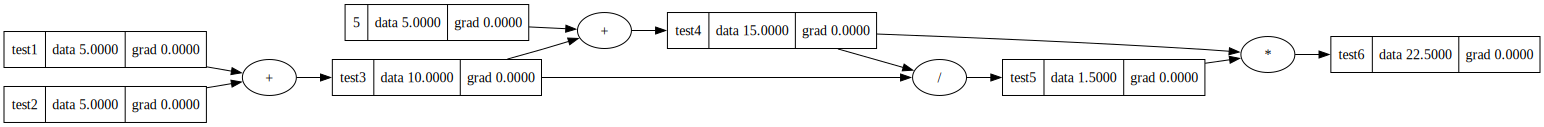

In [4]:
def trace(root):
	nodes, edges = set(), set()

	def traverse(node):
		if node not in nodes:
			nodes.add(node)
			for child in node._children:
				edges.add((child, node))
				traverse(child)
	traverse(root)

	return nodes, edges

#trace(test8)

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{  %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        #remove grad
        #dot.node(name=str(id(n)), label = "{ %s | data %.4f}" % (n.label, n.data), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

draw_dot(test6)

## Testing Backprop on simple network

In [5]:
#inputs x1, x2
x1 = Entity(2, label='x1')
x2 = Entity(0.0, label='x2')

#weights w1, w2
w1 = Entity(-3, label='w1')
w2 = Entity(1, label='w2')

#bias
b = Entity(6.8813735870195432, label='b')

#output
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1_x2w2 = x1w1 + x2w2; x1w1_x2w2.label = 'x1*w1 + x2*w2'
n = x1w1_x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

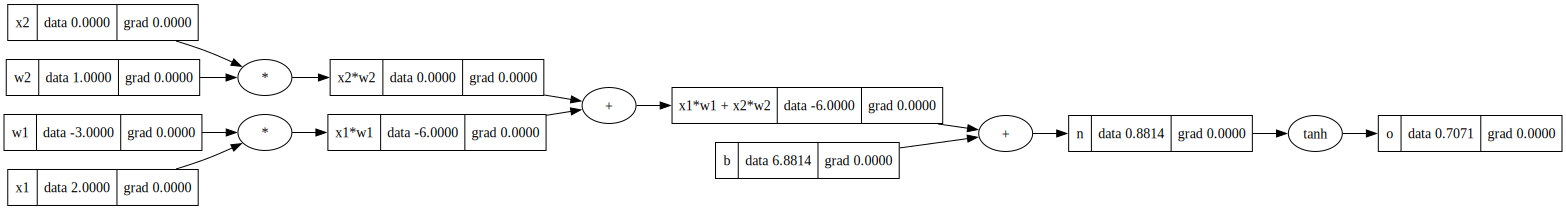

In [6]:
draw_dot(o)

In [14]:
#inputs x1, x2
x1 = Entity(2, label='x1')
x2 = Entity(0.0, label='x2')

#weights w1, w2
w1 = Entity(-3, label='w1')
w2 = Entity(1, label='w2')

#bias
b = Entity(6.8813735870195432, label='b')

#output
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1_x2w2 = x1w1 + x2w2; x1w1_x2w2.label = 'x1*w1 + x2*w2'
n = x1w1_x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'



{'x1': 0.0, 'x2': 0.0, 'w1': 0.0, 'w2': 0.0, 'b': 0.0, 'x1*w1': 0.0, 'x2*w2': 0.0, 'x1*w1 + x2*w2': 0.0, 'n': 0.0, 'o': 0.0}


In [7]:
o._children

(Entity data: 0.8813735870195432,)

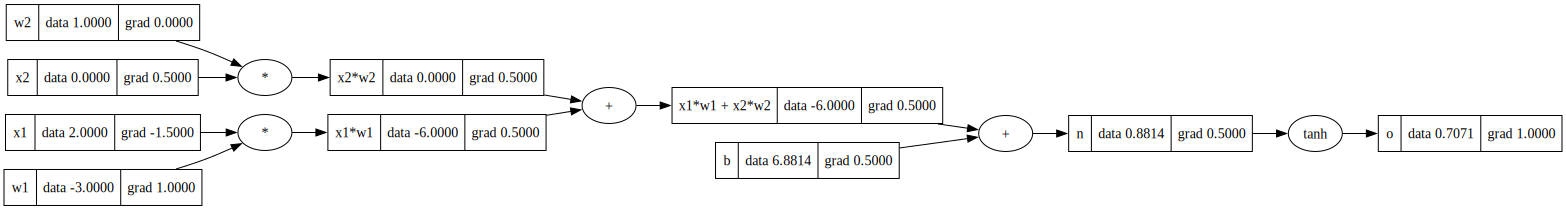

In [15]:
o.backprop()
draw_dot(o)

In [17]:
list_of_objects = [x1, x2, w1, w2, b, x1w1, x2w2, x1w1_x2w2, n, o]

# creat a dict of grad for each object

grad_dict = {}

for obj in list_of_objects:
	grad_dict[obj.label] = round(obj.grad, 2)

print(grad_dict)

{'x1': -1.5, 'x2': 0.5, 'w1': 1.0, 'w2': 0.0, 'b': 0.5, 'x1*w1': 0.5, 'x2*w2': 0.5, 'x1*w1 + x2*w2': 0.5, 'n': 0.5, 'o': 1}


# Starting with Neural Network

In [9]:
class Neuron:

	def __init__(self, no_inputs):
		self.w = [Entity(np.random.normal(-1, 1)) for _ in range(no_inputs)]
		self.b = Entity(np.random.normal(-1, 1))

	def __call__(self, x):
		out = sum([w * x for w, x in zip(self.w, x)], self.b)
		tanh_out = out.tanh()
		return tanh_out
	
	def parameters(self):
		return self.w + [self.b]
	
class Layer:
	def __init__(self, no_inputs, no_neurons):
		self.layer = [Neuron(no_inputs) for _ in range(no_neurons)]

	def __call__(self, x):
		out = [n(x) for n in self.layer]
		return out[0] if len(out) == 1 else out
	
	def parameters(self):
		return [p for neuron in self.layer for p in neuron.parameters()]

class mlp:
	def __init__(self, no_inputs, layer_list):
		self.layer_list = [no_inputs] + layer_list
		self.nn = [Layer(self.layer_list[i-1], self.layer_list[i]) for i in range(1, len(self.layer_list))]

	def __call__(self, x):
		for layer in self.nn:
			x = layer(x)

		return x
	
	def parameters(self):
		return [p for layer in self.nn for p in layer.parameters()]



x = [-1.2, 2.2, 1, 3]
n = Neuron(3)
print("output of neuron:", n(x))

l = Layer(3, 2)
print("output of layer:", l(x))

nn = mlp(3, [4, 4, 1])
print("output of mlp:", nn(x))


output of neuron: Entity data: -0.9999790250242897
output of layer: [Entity data: 0.5708717767245863, Entity data: -0.9225869136229733]
output of mlp: Entity data: -0.8930144713492366


In [10]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
y = [1, 1, -1, -1]



In [13]:
y_pred = [nn(i) for i in xs]

y_pred

[Entity data: 0.9632472500268177,
 Entity data: 0.9852866368562826,
 Entity data: -0.9747981030527507,
 Entity data: -0.9686562069077826]

In [12]:
epochs = 20000

for epoch in range(epochs):

	y_pred = [nn(i) for i in xs]

	loss = sum([(yt - yp) ** 2 for yt, yp in zip(y, y_pred)])
	loss.backprop()

	for param in nn.parameters():
		param.data -= 0.001 * param.grad
		param.grad = 0.0
	
	if epoch % 100 == 0:
		print(f"For Epoch: {epoch}, loss is: {loss.data}")




For Epoch: 0, loss is: 7.971620616677498
For Epoch: 100, loss is: 7.9657041237668915
For Epoch: 200, loss is: 7.956074584083527
For Epoch: 300, loss is: 7.937418125938343
For Epoch: 400, loss is: 7.885055166443402
For Epoch: 500, loss is: 7.23025953862065
For Epoch: 600, loss is: 3.8065486787747203
For Epoch: 700, loss is: 3.5488447666724046
For Epoch: 800, loss is: 3.198341367843932
For Epoch: 900, loss is: 2.9704061675775666
For Epoch: 1000, loss is: 2.8603252461285162
For Epoch: 1100, loss is: 2.8007173052742216
For Epoch: 1200, loss is: 2.7630782733515358
For Epoch: 1300, loss is: 2.736199116098387
For Epoch: 1400, loss is: 2.7150371964227125
For Epoch: 1500, loss is: 2.6969654811572816
For Epoch: 1600, loss is: 2.6803911813310486
For Epoch: 1700, loss is: 2.664166753400342
For Epoch: 1800, loss is: 2.6472840285219945
For Epoch: 1900, loss is: 2.6286579621474147
For Epoch: 2000, loss is: 2.6068971307424404
For Epoch: 2100, loss is: 2.579960038690335
For Epoch: 2200, loss is: 2.5445